# **Problem 3: Adding Different Types of Degradations to Images**

In [29]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.signal import convolve2d
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from numpy.fft import fft2, ifft2, fftshift
from scipy import ndimage

# A.


Found T at pixel locations (row, col) (relative to A's top-left and B1's origin):
  (145, 221)


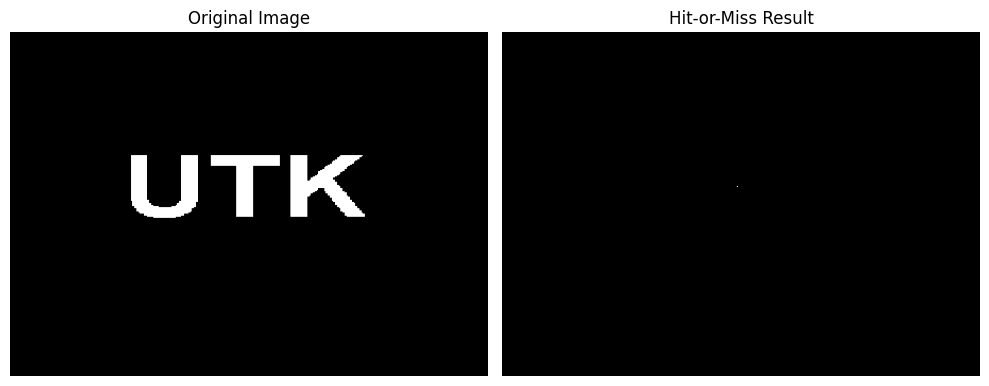

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion 

def erosion(image, se):
    image_h, image_w = image.shape
    se_h, se_w = se.shape
    pad_h, pad_w = se_h // 2, se_w // 2
    output = np.zeros_like(image, dtype=bool) 

    for i in range(pad_h, image_h - pad_h):
        for j in range(pad_w, image_w - pad_w):
            region = image[i - pad_h:i + pad_h + 1, j - pad_w:j + pad_w + 1]
            if region.shape == se.shape:
                if np.all(region[se == 1] == 1):
                    output[i, j] = 1
    return output

def dilation(image, se):
    image_h, image_w = image.shape
    se_h, se_w = se.shape
    pad_h, pad_w = se_h // 2, se_w // 2
    output = np.zeros_like(image, dtype=bool)

    for i in range(image_h):
        for j in range(image_w):
            if image[i, j] == 1:
                for m in range(se_h):
                    for n in range(se_w):
                        if se[m, n] == 1:
                            ni = i + m - pad_h
                            nj = j + n - pad_w
                            if 0 <= ni < image_h and 0 <= nj < image_w:
                                output[ni, nj] = 1
    return output

def hit_or_miss_transform(image, B1, B2):
    hit_result = erosion(image, B1)
    image_complement = ~image 
    miss_result = erosion(image_complement, B2)
    final_result = hit_result & miss_result
    return final_result

def load_and_preprocess_image(filepath):
    try:
        img = imread(filepath)
        if img.ndim == 3: 
            if img.shape[2] == 4:
                img = img[:, :, :3]
            img_gray = rgb2gray(img)
        elif img.ndim == 2: 
            img_gray = img
        else:
            raise ValueError(f"Unsupported image dimensions: {img.ndim} for {filepath}")

        binary_img = img_gray > 0.5
        return binary_img
    except FileNotFoundError:
        print(f"Error: {filepath} not found. Make sure it's in the same directory.")
        exit()
    except Exception as e:
        print(f"An error occurred while loading/processing {filepath}: {e}")
        exit()

A = load_and_preprocess_image('Watermark-Binary.png')
SE_full = load_and_preprocess_image('structuring_element.png')
B1 = SE_full.copy()
B2 = ~SE_full.copy()

hit_or_miss_result = hit_or_miss_transform(A, B1, B2)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax_orig = axes[0]
ax_orig.imshow(A, cmap='gray', origin='upper')
ax_orig.set_title('Original Image')
ax_orig.axis('off') 

ax_hit_miss = axes[1]
ax_hit_miss.imshow(hit_or_miss_result, cmap='gray', origin='upper')
ax_hit_miss.set_title('Hit-or-Miss Result')
ax_hit_miss.axis('off') 

found_rows, found_cols = np.where(hit_or_miss_result == True)
if len(found_rows) > 0:
    print(f"\nFound T at pixel locations (row, col) (relative to A's top-left and B1's origin):")
    for r, c in zip(found_rows, found_cols):
        print(f"  ({r}, {c})")
else:
    print("\nNo 'T' pattern found matching the structuring element.")

plt.tight_layout()
plt.show()